## Cross-Validation with Linear Regression

This notebook demonstrates how to do cross-validation (CV) with linear regression as an example (it is heavily used in almost all modelling techniques such as decision trees, SVM etc.). We will mainly use `sklearn` to do cross-validation.

This notebook is divided into the following parts:
0. Experiments to understand overfitting
1. Building a linear regression model without cross-validation
2. Problems in the current approach
3. Cross-validation: A quick recap
4. Cross-validation in `sklearn`:`
    - 4.1 K-fold CV 
    - 4.2 Parameter tuning using CV
    - 4.3 Other CV schemes

## 0. Experiments to Understand Overfitting

In this section, let's quickly go through some experiments to understand what overfitting looks like. We'll run some experiments using polynomial regression.

In [1]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

## Importing the data

In [2]:
df1=pd.read_csv("Housing.csv")
df1.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [4]:
df1.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [5]:
df1.shape

(545, 13)

#### For the first experiment, we'll do regression with only one feature. Let's filter the data so it only contains area and price.

In [6]:
df=df1[["area","price"]]
df.head()

,area,price
0,7420,13300000
1,8960,12250000
2,9960,12250000
3,7500,12215000
4,7420,11410000


## Rescaling the features
As `area` and `price` are far apart we need rescaling, as we studied in scaling topic

In [7]:
df_cols=df.columns
scaler=MinMaxScaler()

#Fit te columns
df=scaler.fit_transform(df)
df

array([[0.39656357, 1.        ],
       [0.5024055 , 0.90909091],
       [0.57113402, 0.90909091],
       ...,
       [0.13539519, 0.        ],
       [0.08659794, 0.        ],
       [0.15120275, 0.        ]])

In [8]:
# rename columns (since now its an np array)
df=pd.DataFrame(df,columns=df_cols)    
#df.columns=df_cols
df.head()

,area,price
0,0.396564,1.000000
1,0.502405,0.909091
2,0.571134,0.909091
3,0.402062,0.906061
4,0.396564,0.836364


## Visulaize the realtion between area and price

<AxesSubplot:xlabel='area', ylabel='price'>

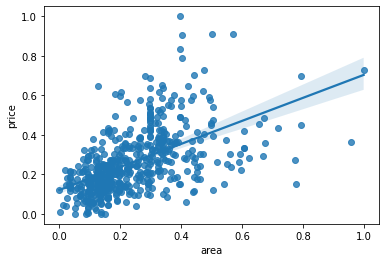

In [9]:
# visualise area-price relationship
sns.regplot(x="area",y="price",data=df)

## Splitting the data into train_test split

In [10]:
df_train,df_test=train_test_split(df,test_size=0.3,random_state=10)
print(len(df_train))
print(len(df_test))

381
164


In [11]:
# split into X and y for both train and test sets
# reshaping is required since sklearn requires the data to be in shape (n, 1), not as a series of shape (n, )
X_train=df_train["area"]
X_train.shape

(381,)

In [12]:
X_train=X_train.values.reshape(-1,1)
y_train=df_train["price"]


# Similarly for X_test
X_test=df_test["area"]
X_test=X_test.values.reshape(-1,1)
y_test=df_test["price"]

In [13]:
X_train.shape

(381, 1)

In [14]:
y_train.shape

(381,)

### Polynomial Regression

You already know simple linear regression:

$y = \beta_0 + \beta_1 x_1$

In polynomial regression of degree $n$, we fit a curve of the form:

$y = \beta_0 + \beta_1 x_1 + \beta_2x_1^2 + \beta_3x_1^3 ... + \beta_nx_1^n$

In the experiment below, we have fitted polynomials of various degrees on the housing data and compared their performance on train and test sets.

In sklearn, polynomial features can be generated using the `PolynomialFeatures` class. Also, to perform `LinearRegression` and `PolynomialFeatures` in tandem, we will use the module `sklearn_pipeline` - it basically creates the features and feeds the output to the model (in that sequence).

In [15]:
len(X_train)

381

Let's now predict the y labels (for both train and test sets) and store the predictions in a table. Each row of the table is one data point, each column is a value of $n$ (degree).

<table style="width:100%">
  <tr>
    <th>   </th>
    <th>degree-1</th>
    <th>degree-2</th> 
    <th>degree-3</th>
    <th>...</th>
    <th>degree-n</th>
  </tr>
  <tr>
    <th>x1</th>
  </tr>
  <tr>
    <th>x2</th>
  </tr>
   <tr>
    <th>x3</th>
    </tr>
    <tr>
    <th>...</th>
    </tr>
    <tr>
    <th>xn</th>
    </tr>
</table>

In [16]:
# fit multiple polynomial features
degrees=[1, 2, 3, 6, 10, 20]

# initialise y_train_pred and y_test_pred matrices to store the train and test predictions
# each row is a data point, each column a prediction using a polynomial of some degree
y_train_pred= np.zeros((len(X_train),len(degrees)))
y_test_pred=np.zeros((len(X_test),len(degrees)))
y_train_pred

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

### Create pipeline to fit various degrees

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [18]:
for i,degree in enumerate(degrees):
    # make pipeline: create features, then feed them to linear_reg model
    
    
     # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)
  

In [19]:
pd.DataFrame(y_train_pred,columns=degrees).head()

,1,2,3,6,10,20
0,0.474187,0.438751,0.439580,0.372839,0.353605,0.396372
1,0.329651,0.360228,0.360203,0.386932,0.397027,0.388243
2,0.195756,0.184723,0.184647,0.168593,0.166606,0.154806
3,0.405466,0.415778,0.416280,0.413291,0.399385,0.374725
4,0.180681,0.158774,0.158847,0.150471,0.144032,0.151538


### visualise train and test predictions

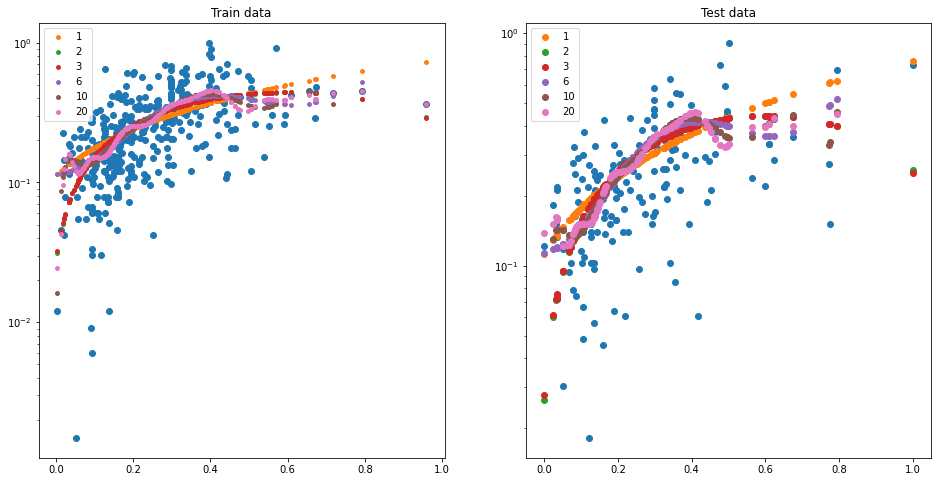

In [20]:
# note that the y axis is on a log scale

plt.figure(figsize=(16, 8))

# train data
plt.subplot(121)
plt.scatter(X_train, y_train)
plt.yscale('log')
plt.title("Train data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_train, y_train_pred[:, i], s=15, label=str(degree))
    plt.legend(loc='upper left')
    
   ## test data
plt.subplot(122)
plt.scatter(X_test, y_test)
plt.yscale('log')
plt.title("Test data")
for i, degree in enumerate(degrees):    
    plt.scatter(X_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')

## compare r2 for train and test sets (for all polynomial fits)

In [21]:
print("R-squared values: \n")
for i,degree in enumerate(degrees):
    train_r2=round(sklearn.metrics.r2_score(y_train,y_train_pred[:,i]),2)
    test_r2=round(sklearn.metrics.r2_score(y_test,y_test_pred[:,i]),2)
    print("Polynomial degree {0}: train score={1}, test score={2}".format(degree, 
                                                                         train_r2, 
                                                                         test_r2))

R-squared values: 

Polynomial degree 1: train score=0.29, test score=0.25
Polynomial degree 2: train score=0.34, test score=0.22
Polynomial degree 3: train score=0.34, test score=0.22
Polynomial degree 6: train score=0.36, test score=0.11
Polynomial degree 10: train score=0.37, test score=-108.76
Polynomial degree 20: train score=0.38, test score=-307420550201.4


## Notice
 - With the increse in polynomial degree test score keeps on decreasing depicts with increse in polynomial degree it cause `Overfit`

## 1. Building a Model Without Cross-Validation

Let's now build a multiple regression model. First, let's build a vanilla MLR model without any cross-validation etc.

In [22]:
# data preparation

# list of all the "yes-no" binary categorical variables
# we'll map yes to 1 and no to 0
binary_vars_list =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# defining the map function
def binary_map(x):
    return x.map(lambda x: 1 if x=="yes" else 0)

# applying the function to the housing variables list
df1[binary_vars_list] = df1[binary_vars_list].apply(binary_map)
df1.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


# Alternate Way

In [23]:
# var_list=['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# for i in df1[var_list]:
#     df1[i]=np.where(df1[i]=="yes",1,0)
# df1

## creating dummies variables

In [24]:
# 'dummy' variables
# get dummy variables for 'furnishingstatus' 
# also, drop the first column of the resulting df (since n-1 dummy vars suffice)
status=pd.get_dummies(df1["furnishingstatus"],drop_first=True)
status.head()

,semi-furnished,unfurnished
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0


In [25]:
# concat the dummy variable df with the main df
df1=pd.concat([df1,status],axis=1)
df1.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished,0,0


In [26]:
# Drop furnishingstatus
df1.drop("furnishingstatus",axis=1,inplace=True)
df1.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0,0


## Splitting into train-test

In [27]:
len(df1["guestroom"].unique())

2

## Scaling

In [28]:
df_train,df_test=train_test_split(df1,train_size=0.7,random_state=100)
# rescale the features
scaler = MinMaxScaler()

# apply scaler() to all the numeric columns 
#numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking','price']
numeric_vars=[i for i in df1.columns if (len(df1[i].unique())>2)]
df_train[numeric_vars] = scaler.fit_transform(df_train[numeric_vars])
df_train.head()

E:\Software_install\anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
359,0.169697,0.155227,0.4,0.0,0.000000,1,0,0,0,0,0.333333,0,0,1
19,0.615152,0.403379,0.4,0.5,0.333333,1,0,0,0,1,0.333333,1,1,0
159,0.321212,0.115628,0.4,0.5,0.000000,1,1,1,0,1,0.000000,0,0,0
35,0.548133,0.454417,0.4,0.5,1.000000,1,0,0,0,1,0.666667,0,0,0
28,0.575758,0.538015,0.8,0.5,0.333333,1,0,1,1,0,0.666667,0,0,1


In [29]:
# apply rescaling to the test set also
df_test[numeric_vars] = scaler.transform(df_test[numeric_vars])
df_test.head()

E:\Software_install\anaconda\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
265,0.229697,0.091869,0.4,0.0,0.333333,1,0,0,0,0,0.000000,1,1,0
54,0.484848,0.366420,0.4,0.5,0.333333,1,1,0,0,1,0.333333,0,1,0
171,0.303030,0.742080,0.4,0.0,0.000000,1,0,0,0,0,0.333333,1,1,0
244,0.242424,0.306582,0.4,0.0,0.333333,1,1,1,0,0,0.000000,1,1,0
268,0.227879,0.274023,0.6,0.0,0.333333,1,0,0,0,1,0.000000,0,1,0


### Divide into X_train, y_train, X_test, y_test

In [30]:
y_train = df_train.pop('price')
X_train = df_train

y_test = df_test.pop('price')
X_test = df_test

Note that we haven't rescaled the test set yet, which we'll need to do later while making predictions.

#### Using RFE 

Now, we have 13 predictor features. To build the model using RFE, we need to tell RFE how many features we want in the final model. It then runs a feature elimination algorithm. 

Note that the number of features to be used in the model is a **Parameter**.

In [31]:
from sklearn.feature_selection import RFE

In [32]:
# first model with an arbitrary choice of n_features
# running RFE with number of features=10
lm=LinearRegression()
lm.fit(X_train, y_train)

rfe=RFE(lm,n_features_to_select=10)
rfe=rfe.fit(X_train,y_train)

In [33]:
# tuples of (feature name, whether selected, ranking)
# note that the 'rank' is > 1 for non-selected features
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('area', True, 1),
 ('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', True, 1),
 ('guestroom', True, 1),
 ('basement', False, 3),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('semi-furnished', False, 4),
 ('unfurnished', False, 2)]

## Make predictions

In [34]:
# predict prices of X_test
y_pred=lm.predict(X_test)
                 
# evaluate the model on test set)
r2=sklearn.metrics.r2_score(y_test,y_pred)
print(r2)

0.6729582743459919


### Try with another value of RFE

In [35]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=6)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = rfe.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.6171279856258437


### NOTE-
- Generally we test on train test before testing the test set data, but in here we check on test feature first by selecting 10 feature and again fed with 6 feature to RFE which is actuallt cheating as we are makingthe model to sneap peek into our test data

## 2. Problems in the Current Approach

In train-test split, we have three options:
1. **Simply split into train and test**: But that way tuning a hyperparameter makes the model 'see' the test data (i.e. knowledge of test data leaks into the model)
2. **Split into train, validation, test sets**: Then the validation data would eat into the training set
3. **Cross-validation**: Split into train and test, and train multiple models by sampling the train set. Finally, just test once on the test set.

## 3. Cross-Validation: A Quick Recap

The following figure illustrates k-fold cross-validation with k=4. There are some other schemes to divide the training set, we'll look at them briefly later.

<img src="cv.png" title="K-Fold Cross Validation" />

## 4. Cross-Validation in sklearn

Let's now experiment with k-fold CV.

In [36]:
X_train.shape

(381, 13)

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [38]:
lm=LinearRegression()
score=cross_val_score(lm,X_train,y_train,cv=5,scoring="r2")
score

array([0.6829775 , 0.69324306, 0.6762109 , 0.61782891, 0.59266171])

### Note-
This score is the score is the score of held out set for eg- in cv1- one set is hed out as test and reamaing is train like that-- like in yellow filled rectange in fig above

## the other way of doing the same thing (more explicit)

In [39]:
# create a KFold object with 5 splits 
folds =KFold(n_splits=5,shuffle=True,random_state=100)
scores=cross_val_score(lm,X_train,y_train,cv=folds,scoring="r2")
scores

array([0.59930574, 0.71307628, 0.61325733, 0.62739077, 0.6212937 ])

In [40]:
# can tune other metrics, such as MSE
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-0.00806336, -0.00658776, -0.0064797 , -0.0070743 , -0.01523682])

#### here negative value means postive of mean_sqaure error, we getting negative because we used "neg_mean_squared_error"

### 4.2 Parameter Tuning Using Grid Search Cross-Validation (to find out suitable numbers of variables)

A common use of cross-validation is for tuning Parameters of a model. The most common technique is what is called **grid search** cross-validation.


<img src="grid_search_image.png"/>

In [41]:
# number of features in X_train
len(X_train.columns)

13

In [43]:
# step-1: create a cross-validation scheme
folds = KFold(n_splits=5,shuffle=True,random_state=100)

# step-2: specify range of hyperparameters to tune
hyper_params =[{"n_features_to_select":list(range(1,len(X_train.columns)+1))}]

In [44]:
hyper_params

[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]

In [50]:
# step-3: perform grid search
# 3.1 specify model
lm=LinearRegression()
lm.fit(X_train,y_train)
rfe=RFE(lm)

# 3.2 call GridSearchCV()
model_cv=GridSearchCV(estimator=rfe,param_grid=hyper_params,scoring="r2",cv=folds,verbose=1,return_train_score=True)
# fit the model
model_cv.fit(X_train,y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    1.3s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

### esitmator- 
- It takes a model in this case its rfe i.e rfe rom linear regression

#### verbose : integer it Controls the verbosity: the higher, the more messages.
- >1 : the computation time for each fold and parameter candidate is displayed;
- >2 : the score is also displayed;
- >3 : the fold and candidate parameter indexes are also displayed together with the starting time of the computation.
#### return_train_score
- It return both the r2 score of `train` as well as `test`, so that we can identify if there is `overfitting` or not.

## CV result

In [51]:
cv_result=pd.DataFrame(model_cv.cv_results_)
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.027996,0.002448,0.002000,0.002449,1,{'n_features_to_select': 1},0.172606,0.351721,0.206887,0.165910,...,0.243658,0.077627,13,0.302971,0.265961,0.280611,0.300768,0.269025,0.283867,0.015506
1,0.027761,0.002298,0.001999,0.002448,2,{'n_features_to_select': 2},0.335665,0.428751,0.439969,0.505321,...,0.438360,0.058374,12,0.505799,0.489802,0.462091,0.474178,0.471907,0.480755,0.015355
2,0.023627,0.002615,0.002000,0.002449,3,{'n_features_to_select': 3},0.421848,0.539257,0.491515,0.604426,...,0.516805,0.059902,11,0.568074,0.544917,0.542889,0.534685,0.542412,0.546596,0.011289
3,0.020710,0.002324,0.003999,0.002000,4,{'n_features_to_select': 4},0.449487,0.567101,0.494461,0.600237,...,0.526272,0.053074,10,0.587523,0.564018,0.549490,0.541496,0.549291,0.558364,0.016296
4,0.016999,0.002450,0.003000,0.002449,5,{'n_features_to_select': 5},0.494779,0.610200,0.492807,0.590812,...,0.541889,0.049257,8,0.620038,0.597033,0.584663,0.549413,0.589397,0.588109,0.022847
5,0.017997,0.003999,0.003000,0.002449,6,{'n_features_to_select': 6},0.512477,0.628849,0.488411,0.527379,...,0.541063,0.048029,9,0.626959,0.603122,0.596348,0.606852,0.601063,0.606869,0.010602
6,0.017000,0.002447,0.002998,0.002448,7,{'n_features_to_select': 7},0.568887,0.664093,0.552385,0.534634,...,0.577636,0.045006,7,0.658577,0.638501,0.630137,0.646285,0.638313,0.642363,0.009582
7,0.014001,0.002001,0.002998,0.002448,8,{'n_features_to_select': 8},0.570639,0.665608,0.592323,0.550001,...,0.591795,0.039428,6,0.674146,0.640825,0.654028,0.658665,0.657277,0.656988,0.010651
8,0.015850,0.005863,0.004000,0.003742,9,{'n_features_to_select': 9},0.578843,0.694189,0.606220,0.590777,...,0.615352,0.040767,4,0.676043,0.652605,0.659579,0.668996,0.664321,0.664309,0.007988
9,0.006998,0.002448,0.002999,0.002449,10,{'n_features_to_select': 10},0.574376,0.693197,0.601972,0.594335,...,0.608547,0.043498,5,0.686032,0.661729,0.674558,0.678443,0.677153,0.675583,0.007910


# Note-
- Here we are interseted in `mean_train_score` and `mean_test_score`

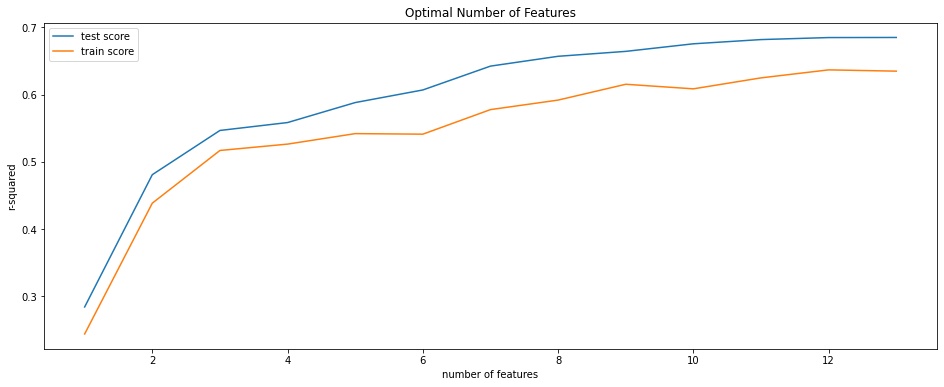

In [55]:
# lets plot to find out the suitable numbers of hyperparametes i.e variables
plt.figure(figsize=(16,6))
plt.plot(cv_result["param_n_features_to_select"],cv_result["mean_train_score"])
plt.plot(cv_result["param_n_features_to_select"],cv_result["mean_test_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

## Note
- In here the optimal numbers of hyperparameter is 10 after that the curve of both train and test flattens.

Now we can choose the optimal value of number of features and build a final model.

In [57]:
# final model
n_features_optimal = 10

lm=LinearRegression()
lm.fit(X_train,y_train)

rfe=RFE(estimator=lm,n_features_to_select=n_features_optimal)
rfe.fit(X_train,y_train)
# predict prices of X_test
y_pred=lm.predict(X_test)
r2=sklearn.metrics.r2_score(y_test,y_pred)
print(r2)

0.6729582743459919


Notice that the test score is very close to the 'mean test score' on the k-folds (about 60%). In general, the mean score estimated by CV will usually be a good estimate of the test score.

# Another Example: Car Price Prediction

In [62]:
# reading the dataset
cars = pd.read_csv("CarPrice_Assignment.csv")
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [63]:
# All data preparation steps in this cell

# converting symboling to categorical
cars['symboling'] = cars['symboling'].astype('object')

import re
from sklearn.preprocessing import scale
# create new column: car_company
p = re.compile(r'\w+-?\w+')
cars['car_company'] = cars['CarName'].apply(lambda x: re.findall(p, x)[0])


# replacing misspelled car_company names
# volkswagen
cars.loc[(cars['car_company'] == "vw") | 
         (cars['car_company'] == "vokswagen")
         , 'car_company'] = 'volkswagen'
# porsche
cars.loc[cars['car_company'] == "porcshce", 'car_company'] = 'porsche'
# toyota
cars.loc[cars['car_company'] == "toyouta", 'car_company'] = 'toyota'
# nissan
cars.loc[cars['car_company'] == "Nissan", 'car_company'] = 'nissan'
# mazda
cars.loc[cars['car_company'] == "maxda", 'car_company'] = 'mazda'


# drop carname variable
cars = cars.drop('CarName', axis=1)


# split into X and y
X = cars.loc[:, ['symboling', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'carheight', 'curbweight', 'enginetype', 'cylindernumber',
       'enginesize', 'fuelsystem', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'car_company']]
y = cars['price']


# creating dummy variables for categorical variables
cars_categorical = X.select_dtypes(include=['object'])
cars_categorical.head()


# convert into dummies
cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)
cars_dummies.head()


# drop categorical variables 
X = X.drop(list(cars_categorical.columns), axis=1)


# concat dummy variables with X
X = pd.concat([X, cars_dummies], axis=1)


# rescale the features
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols


# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=40)

In [64]:
# number of features
len(X_train.columns)

68

In [65]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits=5,shuffle=True,random_state=100)

# specify range of hyperparameters from 2 to 40 as on 1 its carID also we look for 38 features as it is more than enough
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm=LinearRegression()
lm.fit(X_train,y_train)
rfe=RFE(lm)
# set up GridSearchCV()
model_cv=GridSearchCV(rfe,param_grid=hyper_params,scoring="r2",cv=folds,verbose=1,return_train_score=True)
# Fit the model
model_cv.fit(X_train,y_train)

Fitting 5 folds for each of 38 candidates, totalling 190 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:   58.1s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 13, 14, 15, 16, 17,
                                                   18, 19, 20, 21, 22, 23, 24,
                                                   25, 26, 27, 28, 29, 30, 31, ...]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [68]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.346673,0.026938,0.003200,0.003920,2,{'n_features_to_select': 2},0.712322,0.673284,0.839691,0.643727,...,0.716972,0.066867,35,0.693638,0.809346,0.768171,0.798515,0.798908,0.773715,0.042337
1,0.307197,0.002662,0.000000,0.000000,3,{'n_features_to_select': 3},0.817568,0.720574,0.864579,0.675851,...,0.704190,0.147102,38,0.796890,0.868796,0.833999,0.850420,0.845840,0.839189,0.023930
2,0.461962,0.049068,0.000000,0.000000,4,{'n_features_to_select': 4},0.829413,0.812420,0.862303,0.735701,...,0.736991,0.151742,33,0.834392,0.904158,0.894407,0.881821,0.850000,0.872956,0.026557
3,0.341511,0.019856,0.000000,0.000000,5,{'n_features_to_select': 5},0.669211,0.814914,0.864962,0.768708,...,0.710741,0.151825,37,0.863963,0.907896,0.897645,0.911010,0.895627,0.895228,0.016692
4,0.300801,0.011042,0.003200,0.003919,6,{'n_features_to_select': 6},0.675174,0.829293,0.873897,0.764830,...,0.716971,0.153020,36,0.864405,0.910425,0.901539,0.912918,0.909751,0.899808,0.018110
5,0.318321,0.014516,0.000000,0.000000,7,{'n_features_to_select': 7},0.619241,0.825256,0.854447,0.765352,...,0.722678,0.118774,34,0.875107,0.913424,0.909011,0.914559,0.926074,0.907635,0.017213
6,0.323433,0.007788,0.003200,0.003919,8,{'n_features_to_select': 8},0.608348,0.827366,0.848157,0.763983,...,0.768783,0.085134,31,0.887177,0.918335,0.924470,0.914797,0.930265,0.915009,0.014886
7,0.340042,0.041645,0.001600,0.003200,9,{'n_features_to_select': 9},0.638207,0.835079,0.848157,0.763969,...,0.773889,0.074660,29,0.889975,0.921886,0.924470,0.914826,0.934186,0.917069,0.014900
8,0.299172,0.012114,0.001600,0.003201,10,{'n_features_to_select': 10},0.637811,0.819335,0.854378,0.763966,...,0.776128,0.074982,27,0.889975,0.925014,0.931169,0.914828,0.939454,0.920088,0.017068
9,0.284298,0.017298,0.000000,0.000000,11,{'n_features_to_select': 11},0.637811,0.859000,0.860012,0.684470,...,0.770847,0.092361,30,0.889975,0.933753,0.936501,0.924168,0.940519,0.924983,0.018315


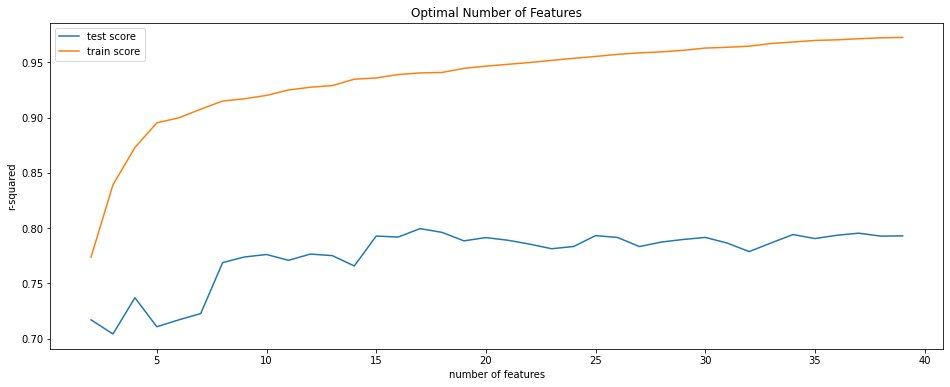

In [70]:
# plotting cv results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

### Final model for Car pricing

In [71]:
# final model
n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.7442758891791716


### 4.3 Types of Cross-Validation Schemes


1. **K-Fold** cross-validation: Most common
2. **Leave One Out (LOO)**: Takes each data point as the 'test sample' once, and trains the model on the rest n-1 data points. Thus, it trains n total models.
    - Advantage: Utilises the data well since each model is trained on n-1 samples
    - Disadvantage: Computationally expensive
3. **Leave P-Out (LPO)**: Creat all possible splits after leaving p samples out. For n data points, there are (nCp) possibile train-test splits.
4. (**For classification problems**) **Stratified K-Fold**: Ensures that the relative class proportion is approximately preserved in each train and validation fold. Important when ther eis huge class imbalance (e.g. 98% good customers, 2% bad).